<a href="https://colab.research.google.com/github/nucontreras/artificial-intelligence-scripts/blob/main/FSCN/Barras/bar_chart_old.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b><FONT size="8" color='264653'>Audiographics Project: sonification for the accessibility of quantitative information in graphic format </FONT>

><b><FONT size="3" color='DimGray'> Sonification for the accessibility of quantitative information in graphic format is part of the research line in Technology and Care of the Millennium Institute for Care Research ([MICARE](https://www.micare.cl/)). The objective of this project is to implement a tool for the transformation of quantitative information presented in visual form into audio to facilitate access to visually handicapped people, using sonification techniques and image analysis through artificial intelligence. </FONT>

><b><FONT size="3" color='DimGray'> This file contains the processing, treatment and tests of a neural network used to filter bar chart images. </FONT>

><b><FONT size="3" color='SlateGray'> Code edited from an old code made in an iPre. </FONT>

<b><FONT size="5" color='MidnightBlue '>Connection to Google Drive </FONT>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd 'gdrive/MyDrive/AudioGraphs'

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1BQNCMYEG1Xd_TAcD5txHIHbOaJiFKKWE/AudioGraphs/Codigos y BD anteriores


<b><FONT size="4" color='619b8a'>Path to bar chart images dataset  </FONT>

In [3]:
path_bar_chart_db = 'Codigos y BD anteriores/Barras/models/'

<b><FONT size="5" color='MidnightBlue '>Import of packages </FONT>



In [24]:
import os
import sys
import numpy as np
from datetime import datetime
from random import shuffle, seed

# Data processing and visualization
import matplotlib.pyplot as plt
import cv2

# AI models
import tensorflow as tf
from keras.utils import Sequence, plot_model
from keras.preprocessing import image
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping

seed(420)

<b><FONT size="5" color='MidnightBlue '>Generator </FONT>


><b><FONT size="3" color='DimGray'> Creation of the generator to pass the images to the model for training it. </FONT>


In [5]:
class DataGenerator(Sequence):
    def __init__(self, directory, targets_dir, color_mode="grayscale", subdirs=False, batch_size=32, dim=(256, 256), n_channels=1, shuffle=True):
        self.x = self.read_directory(directory, subdirs)
        self.directory = directory
        self.targets_dir = targets_dir
        self.len = len(self.x)
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle
#         self.on_epoch_end()

    def read_directory(self, directory, subdirs):
        if not subdirs:
            return os.listdir(directory)
        raise FileExistsError

    def __len__(self):
        return int(self.len // self.batch_size)

    def __getitem__(self, index):
        batch = self.x[index * self.batch_size : (index + 1) * self.batch_size]
        x, y = self.read_images(batch)

        return x, y

    def on_epoch_end(self):
        if self.shuffle == True:
            shuffle(self.x)

    def read_images(self, batch):
        # Inicialización de datos
        # X e y son de igual dimensión ya que ambos son imágenes
        # X : (n_samples, *dim, n_channels)
        x, y = np.empty((self.batch_size, *self.dim, self.n_channels)), np.empty((self.batch_size, *self.dim, self.n_channels))

        # Generación de data
        for i, name in enumerate(batch):
            path = self.directory + "/" + name
            img = tf.keras.utils.load_img(path, target_size=(256, 256), color_mode = "grayscale")
            img = tf.keras.utils.img_to_array(img)
            x[i] = img / 255

            target_path = self.targets_dir + "/" + name
            target_img = tf.keras.utils.load_img(target_path, target_size=(256, 256), color_mode = "grayscale")
            target_img = tf.keras.utils.img_to_array(target_img)
            y[i] = target_img / 255

        return x, y

Creation of generators for training and testing

In [6]:
BATCH_SIZE = 32

train_path_x = path_bar_chart_db + "dataset/segmentation-2/train/color"
train_path_y = path_bar_chart_db + "dataset/segmentation-2/train/segmented"

test_path_x = path_bar_chart_db + "dataset/segmentation-2/test/color"
test_path_y = path_bar_chart_db + "dataset/segmentation-2/test/segmented"

train_gen = DataGenerator(train_path_x, train_path_y, batch_size=BATCH_SIZE)
test_gen = DataGenerator(test_path_x, test_path_y)

In [7]:
print(f"Input Format: {train_gen[0][0][0].shape}\nOutput Format (mask): {train_gen[0][1][0].shape}")
print(f"Data type input: {train_gen[0][0][0].dtype}\nData type output (mask): {train_gen[0][1][0].dtype}")

Input Format: (256, 256, 1)
Output Format (mask): (256, 256, 1)
Data type input: float64
Data type output (mask): float64


In [8]:
train_gen

In [9]:
def generador(directory, targets_dir, imgs, batch_size):
    index = 0
    while True:
        batch = imgs[index * batch_size : (index + 1) * batch_size]
        x, y = np.empty((batch_size, 128, 128, 1)), np.empty((batch_size, 128, 128, 1))

        for i, name in enumerate(batch):
            path = directory + "/" + name
            img = tf.keras.utils.load_img(path, target_size=(128, 128), color_mode = "grayscale")
            img = tf.keras.utils.img_to_array(img)
            x[i] = img / 255

            target_path = targets_dir + "/" + name
            target_img = tf.keras.utils.load_img(target_path, target_size=(128, 128), color_mode = "grayscale")
            target_img = tf.keras.utils.img_to_array(target_img)
            y[i] = target_img / 255

        index += 1
        if index == len(imgs) // batch_size:
            index = 0
        yield x, y

In [10]:
dir_list = os.listdir(train_path_x)
train_gen = generador(train_path_x, train_path_y, dir_list, 64)

<b><FONT size="5" color='MidnightBlue '>Without generators </FONT>

Read all the images and leave them in a huge list

In [14]:
files = [
    "file1",
    "file2.jpg",
    "file123",
    "file4.jpg.old",
    "file5.txt"
]

extensions = (
    ".jpg",
    ".exe",
    ".txt"
)

for file in files:
    if not file.endswith(extensions):
        print(f'File :{file} should be delete')
    else:
        print(f'Skipping:{file}')

File :file1 should be delete
Skipping:file2.jpg
File :file123 should be delete
File :file4.jpg.old should be delete
Skipping:file5.txt


In [15]:
def load_img(img_path, gray=True):
    img = tf.keras.utils.load_img(img_path, target_size=(128, 128), color_mode = "grayscale")
    img = tf.keras.utils.img_to_array(img)
    return img / 255

def load_dataset(directory):
    dir_list = os.listdir(directory)
    dir_len = len(dir_list)
    imgs = np.empty((dir_len, 128, 128, 1))
    for i, name in enumerate(dir_list):
        name = directory + "/" + name
        imgs[i] = load_img(name)
    return imgs

In [16]:
# Solve problem with ._ files

x_train = load_dataset(train_path_x)
y_train = load_dataset(train_path_y)

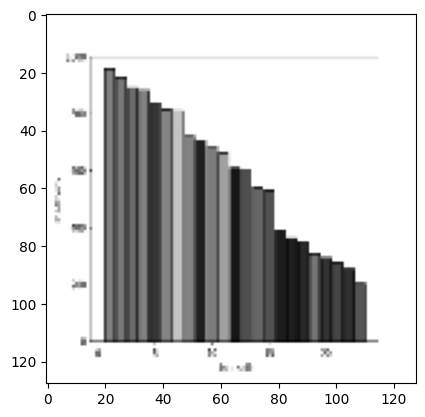

In [17]:
plt.imshow(x_train[0], cmap="gray")

<b><FONT size="5" color='MidnightBlue '>FSCN Model </FONT>

- We defined the model based on the conv-deconv architecture of the paper "Fully Symmetric Convolutional Network for Effective
Image Denoising".

- Returns a grayscale image. Then you have to do threshhold to see the bars well, so it is not very accurate.

In [18]:
#with tf.device('/device:GPU:0'):
input_layer = Input(shape=(128, 128, 1), name="INPUT")
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
output_layer = Conv2D(1, (3, 3), padding='same', name="OUTPUT")(x)

model = Model(input_layer, output_layer)
model.compile(optimizer='adam', loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (InputLayer)          [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 conv2d_transpose (Conv2DTra  (None, 128, 128, 64)     36928     
 nspose)                                                         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 128, 128, 64)     36928     
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      36928 

<b><FONT size="5" color='MidnightBlue '>Training </FONT>

In [22]:
print(len(train_gen))

def gen(seq):
    i = 0
    while True:
        yield seq[i]
        i += 1

generador = gen(train_gen)

TypeError: ignored

In [21]:
print(train_gen[0][0].shape)
sys.getsizeof(train_gen[0][0][0])

TypeError: ignored

In [ ]:
history = model.fit(train_gen,
                    # y_train,
                    # batch_size=BATCH_SIZE,
                    steps_per_epoch=len(dir_list) // 64 - 1,
                    verbose=1,
                    epochs=20)

In [23]:
# Early Stopping
# es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience = 5, restore_best_weights = True)

#with tf.device('/device:GPU:0'):
BATCH_SIZE = 64
STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE
EPOCHS = 20
history = model.fit(x_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    verbose=1,
                    epochs=EPOCHS)

Epoch 1/20
78/78 [==============================] - 59s 547ms/step - loss: 0.2090
Epoch 2/20
78/78 [==============================] - 44s 564ms/step - loss: 0.1132
Epoch 3/20
78/78 [==============================] - 43s 552ms/step - loss: 0.1092
Epoch 4/20
78/78 [==============================] - 43s 557ms/step - loss: 0.1071
Epoch 5/20
78/78 [==============================] - 43s 556ms/step - loss: 0.1060
Epoch 6/20
78/78 [==============================] - 43s 556ms/step - loss: 0.1052
Epoch 7/20
78/78 [==============================] - 43s 555ms/step - loss: 0.1054
Epoch 8/20
78/78 [==============================] - 43s 552ms/step - loss: 0.1123
Epoch 9/20
78/78 [==============================] - 43s 553ms/step - loss: 0.1067
Epoch 10/20
78/78 [==============================] - 43s 555ms/step - loss: 0.1058
Epoch 11/20
78/78 [==============================] - 43s 555ms/step - loss: 0.1059
Epoch 12/20
78/78 [==============================] - 43s 554ms/step - loss: 0.1056
Epoch 13/20
7

<b><FONT size="5" color='MidnightBlue '>Evaluation </FONT>

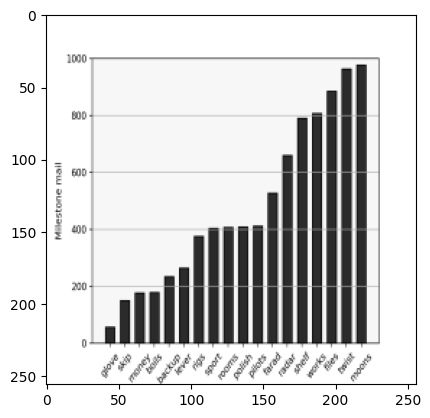

In [30]:
n = 10
img_path = path_bar_chart_db + f"dataset/segmentation-2/train/grises/{n}.png"
img = tf.keras.utils.load_img(img_path, target_size=(256, 256), color_mode = "grayscale")
img = tf.keras.utils.img_to_array(img) [:,:,0] / 255

plt.imshow(img, cmap="gray")


In [31]:
def evaluate(model, img_path):
    "Recibe un modelo y un path a una imagen y retorna la imagen y el output como np arrays"
    img = tf.keras.utils.load_img(img_path, target_size=(128, 128), color_mode = "grayscale")
    img = tf.keras.utils.img_to_array(img) / 255
    # print(img.shape)
    segmented = model.predict(img)
    return img[:,:,0], segmented[:,:,:,0]

def normalize_img(img):
    return (img - img.min()) / (img.max() - img.min())

4/4 [==============================] - 1s 4ms/step


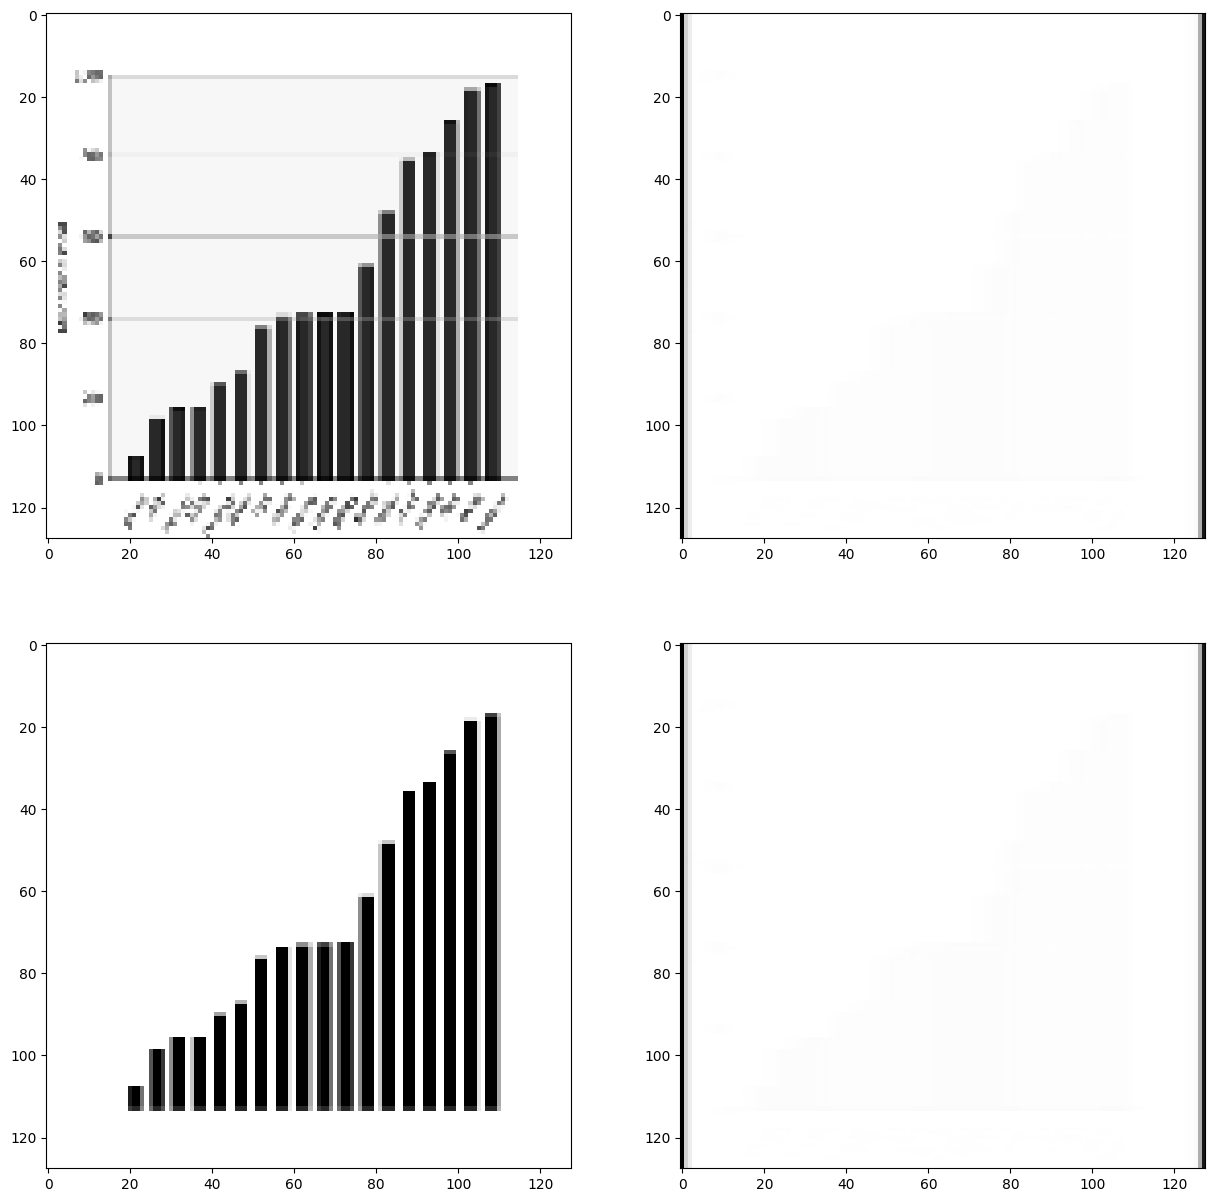

In [32]:
n = 10
img_path = path_bar_chart_db + f"dataset/segmentation-2/train/grises/{n}.png"
target_path = path_bar_chart_db + f"dataset/segmentation-2/train/segmented/{n}.png"

img, segmented = evaluate(model, img_path)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(15, 15)
# plt.imshow(img)

ax1.imshow(img, cmap="gray")
ax2.imshow(segmented[:,:,0], cmap="gray")

target = tf.keras.utils.load_img(target_path, target_size=(128, 128), color_mode = "grayscale")
target = tf.keras.utils.img_to_array(target) [:,:,0]
ax3.imshow(target, cmap="gray")

# print(segmented)
ax4.imshow(normalize_img(segmented)[:,:,0], cmap="gray")

# print(normalize_img(segmented))
# print(segmented)

# print(segmented[150], img[150])

# print(segmented[:, :, :, 0])

<b><FONT size='5' color='MidnightBlue' >Save Model</FONT></b>

In [33]:
path_bar_chart_db

'Barras/models/'

In [ ]:
def save_model(model, name=None):
    "guarda un modelo como h5, si no tiene nombre se guarda con un timestamp"
    path = drive_path + "models/"
    if name == None:
        td = datetime.now()
        name = f"{td.year}-{td.year}-{td.day}_{td.hour}-{td.minute}-{td.second}"
    model.save(path + name + ".h5", save_format="h5")

def load_model(model_path):
    return tf.keras.models.load_model(model_path)

save_model(model, name="FSCN2")

In [ ]:
def show_data(model_path, img_path):
    model = load_model(model_path) # CARGADO DEL MODELO
    # IMG EN NP ARRAY (1, 256, 256, 1)
    full_img = []
    img = tf.keras.utils.load_img(img_path, target_size=(128, 128), color_mode = "grayscale")
    img = tf.keras.utils.img_to_array(img)
    img = ((img - img.min())/(img.max() - img.min())) #MIN MAX
    full_img.append(img)
    full_img = np.array(full_img)
    # PREDICCION
    pred = model.predict(full_img)
    # NORMALIZACIÓN
    pred = ((pred - pred.min())/(pred.max() - pred.min()))

    # THRESHOLD
    thresh = cv2.threshold(pred[0,:,:,0], 0.8, 1, cv2.THRESH_BINARY)
    thresh = thresh[1].reshape(256,256)

    # ERODE-DILATE
    kernel = np.ones((3,3),np.uint8)
    erosion = cv2.erode(thresh,kernel,iterations = 1)
    dilate = cv2.dilate(erosion, kernel, iterations = 1)

    #DISPLAY
    plt.figure(figsize=(15, 15))
    plt.gray()
    ax = plt.subplot(2,2,1)
    plt.imshow(full_img.reshape(256,256))
    ax = plt.subplot(2,2,2)
    plt.imshow(pred.reshape(256,256))
    ax = plt.subplot(2,2,3)
    plt.imshow(thresh.reshape(256,256))
    ax = plt.subplot(2,2,4)
    plt.imshow(dilate.reshape(256,256))

In [ ]:
model_path = drive_path + "models/FSCN1.h5"
n = 3
img_path = f"{drive_path}segmentation-2/test/grises/{n}.png"
target_path = f"{drive_path}segmentation-2/train/segmented/{n}.png"

show_data(model_path, img_path)

In [ ]:
plot_model(model)

In [ ]:
# Add load model here.

Load model

In [ ]:
m = load_model(model_path + '2021-2021-18_15-28-38.h5')
m.summary()

In [ ]:
dir(m)
m.losses

In [ ]:
plot_model(m)

In [ ]:
def minmax(img):
  img = (img - img.min())/(img.max() - img.min()) #MIN MAX
  return img

def test_model(model, img_path, img_shape, target_path=None):
  # IMG EN NP ARRAY (1, 256, 256, 1)
  # full_img = []
  img = tf.keras.utils.load_img(img_path, target_size=(256,256), color_mode = "grayscale") #, interpolation="bicubic")
  img = tf.keras.utils.img_to_array(img)
  # img = minmax(img)

  # PREDICCION
  pred = model.predict(img[None,:,:,:]).reshape((256, 256))
  img = img.reshape((256, 256))

  # NORMALIZACIÓN
  # pred = ((pred - pred.min())/(pred.max() - pred.min()))
  # print(pred[0].shape)
  # print(minmax(pred))
  ret, thresh = cv2.threshold(minmax(pred), 0.5, 1, cv2.THRESH_BINARY)

  #DISPLAY
  plt.figure(figsize=(15, 15))
  plt.gray()
  ax = plt.subplot(2,2,1)
  plt.imshow(img)
  ax = plt.subplot(2,2,2)
  plt.imshow(pred)
  ax = plt.subplot(2,2,3)
  plt.imshow(thresh)

  # ax = plt.subplot(2,2,3)
  # plt.imshow(1-new)
  # ax = plt.subplot(2,2,4)
  # plt.imshow(onepixel_img(new))
  if target_path:
    target = tf.keras.utils.load_img(target_path, target_size=(256,256), color_mode = "grayscale") #, interpolation="bicubic")
    target = tf.keras.utils.img_to_array(target)
    ax = plt.subplot(2,2,4)
    plt.imshow(target[:,:,0])

In [ ]:
target_path = None
n = 1
# img_path = drive_path + f"dataset/segmentation-2/test/color/{n}.png"
img_path = drive_path + f"ejemplos/internet/buenos/1000.jpg"
# target_path = drive_path + f"dataset/segmentation-2/test/segmented/{n}.png"

# img_path = drive_path + "DB graficos internet/Barras Verticales/Copia de graph_1003.jpg"
m = load_model(model_path + '2021-2021-18_15-28-38.h5')

test_model(m, img_path, (256, 256), target_path)

In [ ]:
def segment(img_path, model):
  img = tf.keras.utils.load_img(img_path, target_size=(256,256), color_mode = "grayscale") #, interpolation="bicubic")
  img = tf.keras.utils.img_to_array(img)

  # PREDICCION
  pred = model.predict(img[None,:,:,:]).reshape((256, 256))
  img = img.reshape((256, 256))

  ret, thresh = cv2.threshold(minmax(pred), 0.5, 1, cv2.THRESH_BINARY)
  return thresh.astype(np.uint8)

  # m = load_model(model_path + models[0])

In [ ]:
n = 1016
img_path = drive_path + f"ejemplos/internet/buenos/{n}.jpg"
target_path = drive_path + f"dataset/segmentation-2/test/segmented/{n}.png"

img_path = drive_path + "models/dataset/DB graficos internet/Barras Verticales/Copia de graph_1003.jpg"

# print(segmented.astype(np.uint8).dtype)

segmented = segment(img_path, m)

# Invert de blanco con negro para encontrar los contours
contours, hierarchy = cv2.findContours(np.where((segmented==0), 1, 0).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

plt.figure(figsize=(15,15))
plt.subplot(2, 2, 1)
plt.imshow(segmented)

img = cv2.drawContours(cv2.cvtColor(segmented * 255, cv2.COLOR_GRAY2RGB), contours, -1, (0,255,0), 1)

plt.subplot(2, 2, 2)
plt.imshow(img)


plt.subplot(2, 2, 3)
plt.imshow(cv2.drawContours(np.ones((256, 256, 3)) * 255, contours, -1, (0,255,0), 2))

contours = [c for c in contours if c.shape[0] > 3]
print(len(contours))
# print(hierarchy)

img = np.ones((256, 256, 3)) * 255
for bar in contours:
  x_min = bar[:,0,0].min()
  x_max = bar[:,0,0].max()
  y_min = bar[:,0,1].min()
  y_max = bar[:,0,1].max()

  cv2.rectangle(img,(x_min, y_min), (x_max, y_max), (0,255,0), 1)
plt.subplot(2, 2, 4)
plt.imshow(img)


In [ ]:
def test_and_save():
    pass

def test_and_save_image(model, img_path, img_name, save_dir, display=True):

    img = tf.keras.utils.load_img(img_path, target_size=(256,256), color_mode = "grayscale") #, interpolation="bicubic")
    img = tf.keras.utils.img_to_array(img)

    # PREDICCION
    pred = model.predict(img[None,:,:,:]).reshape((256, 256))
    img = img.reshape((256, 256))

    # NORMALIZACIÓN
    ret, thresh = cv2.threshold(minmax(pred), 0.5, 1, cv2.THRESH_BINARY)

    # Contornos
    # Invert de blanco con negro para encontrar los contours
    contours, hierarchy = cv2.findContours(np.where((thresh==0), 1, 0).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = [c for c in contours if c.shape[0] > 3]
    # print(len(contours))

    contour_img = np.ones((256, 256, 3)) * 255
    final_img = tf.keras.utils.load_img(img_path, target_size=(256,256))
    final_img = tf.keras.utils.img_to_array(final_img).astype(np.uint8)
    # print(final_img.dtype)
    for bar in contours:
        x_min = bar[:,0,0].min()
        x_max = bar[:,0,0].max()
        y_min = bar[:,0,1].min()
        y_max = bar[:,0,1].max()

    cv2.rectangle(contour_img,(x_min, y_min), (x_max, y_max), (0,255,0), 1)
    cv2.rectangle(final_img,(x_min, y_min), (x_max, y_max), (0,255,0), 2)

    # DISPLAY
    if display:
        plt.figure(figsize=(15, 15))
        plt.gray()
        plt.subplot(2,3,1)
        plt.imshow(img)
        plt.subplot(2,3,2)
        plt.imshow(pred)
        plt.subplot(2,3,3)
        plt.imshow(thresh)
        plt.subplot(2, 3, 4)
        plt.imshow(contour_img)
        plt.subplot(2, 3, 5)
        plt.imshow(final_img)

    # Save
    plt.imsave(save_dir + f"1_grayscale_reshape/{img_name}", img)
    plt.imsave(save_dir + f"2_output_red/{img_name}", pred)
    plt.imsave(save_dir + f"3_threshold/{img_name}", thresh)
    plt.imsave(save_dir + f"4_contornos/{img_name}", contour_img / 255)
    plt.imsave(save_dir + f"5_contornos_sobre_original/{img_name}", final_img)


In [ ]:
# img_path = drive_path + f"dataset/segmentation-2/test/segmented/{n}.png"
# test_and_save_image(m, img_path)
imgs_path = drive_path + "models/dataset/segmentation-2/test/color"

for img_name in os.listdir(imgs_path):
  img_path = drive_path + f"models/dataset/segmentation-2/test/color/{img_name}"
  save_dir = drive_path + "models/dataset/segmentation-2/test/output/"
  test_and_save_image(m, img_path, img_name, save_dir, display=False)


In [ ]:
imgs_path = drive_path + "models/dataset/internet/0_originales/"

for img_name in os.listdir(imgs_path):
    img_path = imgs_path + img_name
    save_dir = drive_path + "models/dataset/internet/"
    test_and_save_image(m, img_path, img_name, save_dir, display=False)